In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import math

In [3]:
import popoff
from Session import SessionLite
from mpl_toolkits.mplot3d import Axes3D
from linear_model import PoolAcrossSessions, LinearModel, pca_session, LabelEncoder
import loadpaths
from scipy import stats, signal
from sklearn.linear_model import LinearRegression, Lasso

figure_path = '/home/jrowland/mnt/qnap/Figures/bois'

/home/jrowland/Documents/code/pop-off/popoff/popoff/loadpaths.py


In [4]:
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

In [5]:
remove_targets = True
pas = PoolAcrossSessions(save_PCA=False, remove_targets=remove_targets)
lm = pas.linear_models[0]

In [6]:
def get_covariates(lm, region, outcomes=['hit', 'miss'], remove_easy=False):
    
    n_comps_include = 5
    covariate_dict, y = lm.prepare_data('all', 'partial', n_comps_include=n_comps_include,
                            outcomes=outcomes,
                            region=region, return_matrix=False, remove_easy=remove_easy)
    
    
#     for i in range(n_comps_include):
#         covariate_dict[f'PC{i}'] = covariate_dict['PCs'][i, :]
            
    covariate_dict['y'] = y
    
    covs_keep = ['mean_pre', 'corr_pre',  'largest_PC_var', 'flat', 'lick', 'reward',
#                  f'ts_{region}_pre', 'reward_history', 'trial_number', 'n_cells_stimmed']
                 'ts_s1_pre', 'ts_s2_pre', 'reward_history', 'trial_number', 'n_cells_stimmed']
    
    return {k:v for k,v in covariate_dict.items() if k in covs_keep}

In [7]:
def propgation_coefs(lm, tt_include=['hit', 'miss'], remove_easy=False):
    
    # Get the covariates as a matrix and store their string names
    X = get_covariates(lm, 's1', outcomes=tt_include, remove_easy=remove_easy)
    labels = list(X.keys())
    X = lm.dict2matrix(X)
    
    # Build a boolean to index the flu matrix
    outcomes = lm.session.outcome
    trial_bool = np.isin(outcomes, tt_include)
    print(sum(trial_bool))
    if remove_easy:
        test_and_catch = lm.session.photostim != 2
        trial_bool = np.logical_and(trial_bool, test_and_catch)
        
    # Mean s2 post - Mean s2 pre
    flu = lm.flu
    # Narrowed the window compared to linear_model class
    post_frames = np.logical_and(lm.times_use>1, lm.times_use < 2)
    
    y = (np.mean(flu[:, :, post_frames], (0,2)) - 
                np.mean(flu[:, :, lm.frames_map['pre']], (0,2)))
    y = y[trial_bool]

    # Fit regression model
    # model = LinearRegression()
    model = Lasso(alpha=1e-3)
    model.fit(X, y)
    
    # Plot each fold's betas as points
    x_pos = 0
    for label, beta in zip(labels, model.coef_):
        plt.plot(x_pos, beta, '.', color=COLORS[0], label=label, markersize=9)
        x_pos += 1

    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.axhline(0, linestyle=':')
    plt.title(f'Model r^2 is {round(model.score(X, y), 2)}')
    plt.ylabel(r'$\beta$')


67


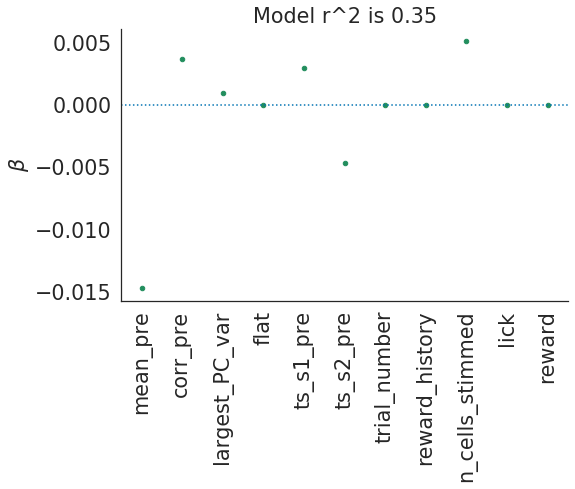

In [8]:
plt.figure(figsize=(8,5))
propgation_coefs(lm, tt_include=['hit'], remove_easy=False)

In [9]:
lm.session.__dict__.keys()

dict_keys(['mouse', 'run_number', 'flu_flavour', 'pkl_path', 'pre_seconds', 'post_seconds', 'pre_gap_seconds', 'post_gap_seconds', 'verbose', 'filter_threshold', 'name', 'tstart_galvo', 'trial_start', 'galvo_ms', 'subsets', 'trial_subsets', 'n_stim_arr', 'outcome', 'outcome_arr', 'frequency', 'pre_frames', 'post_frames', 'art_gap_start', 'final_pre_gap_tp', 'art_gap_stop', 'filter_ps_array', 'filter_ps_time', 'behaviour_trials', 'pre_rew_trials', 'unfiltered_n_cells', 'filtered_neurons', 'n_cells', 'av_ypix', 'av_xpix', 'plane_number', 's1s2_border', 's2_bool', 's1_bool', 'decision', 'photostim', 'photostim_occ', 'autorewarded', 'unrewarded_hits', 'n_unique_stims', 'n_neurons', 'n_times', 'n_trials', 'n_unique_dec', 'occ_table', 'n_com_trials', 'is_target', 'nonnan_trials', 'frames_use', 'tau_dict'])

In [11]:
no_norm = lambda x:x

In [12]:
def session_propagation(lm, cov_name):
    
    outcomes_keep = ['hit']
    norm_func = no_norm
    remove_easy = False
    
    outcomes = lm.session.outcome

    covariate_dict = get_covariates(lm, 's1', outcomes=outcomes_keep, remove_easy=remove_easy)
    s1_vector = covariate_dict[cov_name]

    trial_bool = np.isin(outcomes, outcomes_keep)
    ## DO you wana include easys? ####
    if remove_easy:
        test_and_catch = lm.session.photostim != 2
        trial_bool = np.logical_and(trial_bool, test_and_catch)

    # Kinda awkward defining this every time
    flu = lm.flu[lm.region_map['s2'], :, :]
    flu = flu[:, trial_bool, :]
    s2_vector = (np.mean(flu[:, :, lm.frames_map['post']], (0,2)) - 
                 np.mean(flu[:, :, lm.frames_map['pre']], (0,2)))
    
    return norm_func(s1_vector), norm_func(s2_vector)

In [28]:
def propagation_plot(cov_name):
    
    s1_vector = []
    s2_vector = []

    for lm in pas.linear_models:
        
        io = session_propagation(lm, cov_name)
        s1_vector.append(io[0])
        s2_vector.append(io[1])

    s1_vector = np.concatenate(s1_vector) * 100
    s2_vector = np.concatenate(s2_vector)

    plt.plot(s1_vector, s2_vector, '.', color='black', alpha=1)
    
    # Plot the regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(s1_vector, s2_vector)
    x_lims = (min(s1_vector), max(s1_vector))
    y_lims = (min(s2_vector), max(s2_vector))
    x = np.linspace(x_lims[0], x_lims[1], 3)
    plt.plot(x, intercept + slope * x, '-', color='black')
    plt.text((x_lims[1] + x_lims[0]), (y_lims[1] + y_lims[0])/1, 
             f'r^2 = {round(r_value**2, 2)}\ngradient = {round(slope, 4)}\np={p_value:.2e}',
            fontsize=16)
    
    plt.xlabel(cov_name)
    plt.ylabel('Change in activity in S2 \n' +  r'($\Delta$F/F)')
    plt.savefig(os.path.join(figure_path, 'PCproppy.pdf'),bbox_inches="tight")
    plt.savefig(os.path.join(figure_path, 'PCproppy.png'),bbox_inches="tight")

Text(0.5, 2.5, '% variance explained\nby 1st PC')

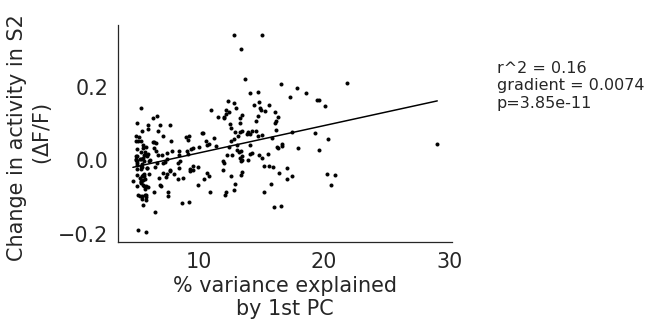

In [29]:
propagation_plot('largest_PC_var')
plt.xlabel('% variance explained\nby 1st PC')

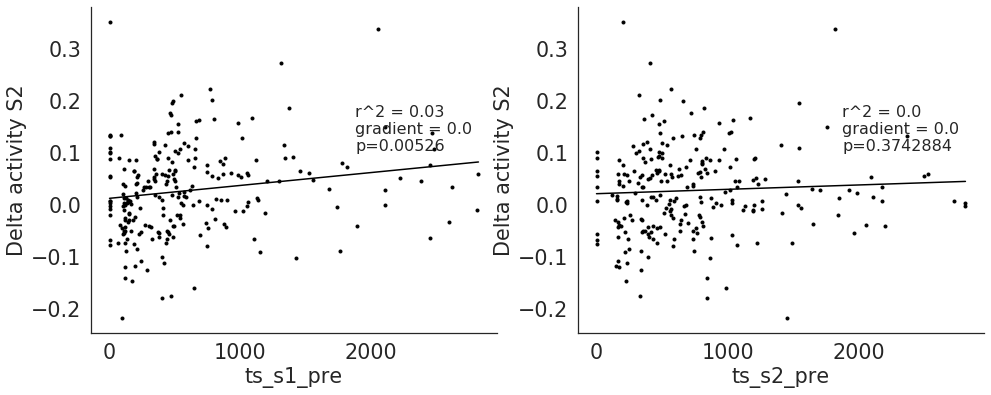

In [59]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1,)
propagation_plot('ts_s1_pre')
plt.subplot(1,2,2,)
propagation_plot('ts_s2_pre')

# Scatter Plot Covariates vs delta s2 individual trial types

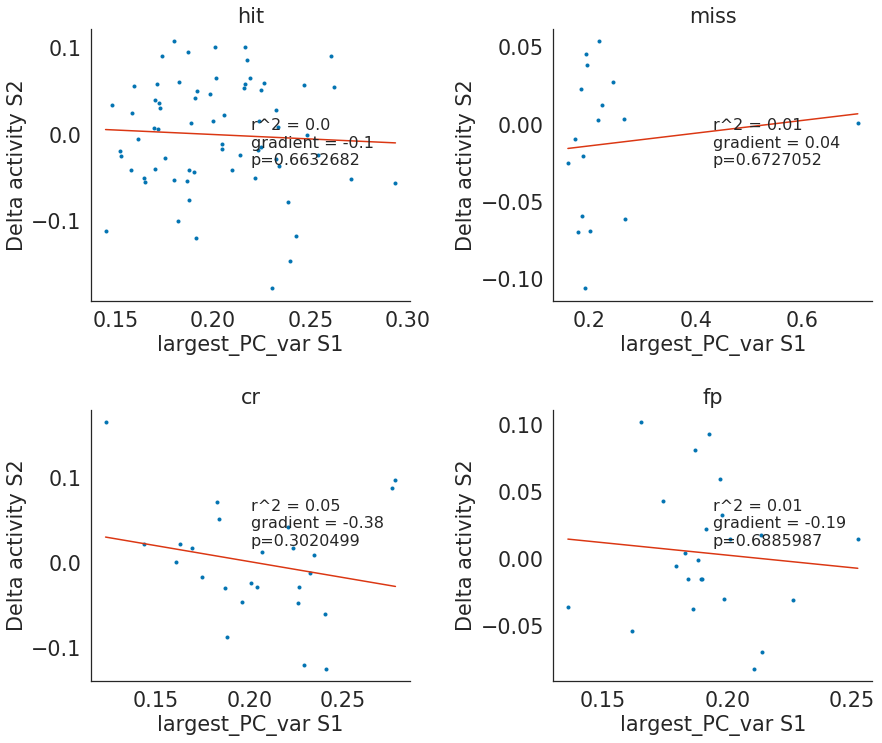

In [11]:

lm = pas.linear_models[0]
cov_name = 'largest_PC_var'
# flu = flu[:, :, lm.frames_map['pre']]

outcomes = lm.session.outcome

plt.figure(figsize=(14,12))
n_plots = 0 
for tt in ['hit', 'miss', 'cr', 'fp']:
    
    covariate_dict = get_covariates(lm, 's1', outcomes=[tt])
    s1_vector = covariate_dict[cov_name]
    
    trial_bool = np.isin(outcomes, tt)
#     test_and_catch = lm.session.photostim != 2
#     trial_bool = np.logical_and(trial_bool, test_and_catch)
    # Kinda awkward defining this every time
    flu = lm.flu[lm.region_map['s2'], :, :]
    flu = flu[:, trial_bool, :]
    
    s2_vector = (np.mean(flu[:, :, lm.frames_map['post']], (0,2)) - 
                np.mean(flu[:, :, lm.frames_map['pre']], (0,2)))
#     s1_vector = cov[trial_bool]
    
    n_plots += 1
    plt.subplot(2,2,n_plots)
    plt.plot(s1_vector, s2_vector, '.')
    plt.title(tt)
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(s1_vector, s2_vector)
    x_lims = plt.gca().get_xlim()
    x_lims = (min(s1_vector), max(s1_vector))
    y_lims = plt.gca().get_ylim()
    y_lims = (min(s2_vector), max(s2_vector))
    x = np.linspace(x_lims[0], x_lims[1], 3)
    
    plt.plot(x, intercept + slope * x, '-', color=COLORS[1])
    plt.text((x_lims[1] + x_lims[0])/2, (y_lims[1] + y_lims[0])/2, 
             f'r^2 = {round(r_value**2, 2)}\ngradient = {round(slope, 2)}\np={round(p_value,7)}',
            fontsize=16)
    plt.xlabel(cov_name + ' S1')
    plt.ylabel('Delta activity S2')

plt.subplots_adjust(wspace=0.45, hspace=0.4)
    
    